In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH_CHK = '/content/gdrive/MyDrive/chk'

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
device = torch.device("cuda")
import numpy as np

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
valset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=16,shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class vae(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,4,2,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,4,2,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.feature_size = 4
        self.feature_vol = 128*(self.feature_size ** 2)

        self.q_mean = nn.Linear(self.feature_vol,128)

        self.q_logvar = nn.Linear(self.feature_vol,128)

        self.project = nn.Linear(128,self.feature_vol)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64,kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32,3,4,2,1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            # nn.Tanh()
            nn.Sigmoid()
        )

    def forward(self,x):
            encode = self.encoder(x)
            mean, logvar = self.q(encode)
            z = self.z(mean, logvar)
            z_projected = self.project(z).view(
                -1, 128,
                4,
                4,
            )
            decode = self.decoder(z_projected)
            return (mean, logvar), decode

    def q(self,encoded):
        unenrolled = encoded.view(-1,self.feature_vol)
        return self.q_mean(unenrolled),self.q_logvar(unenrolled)

    def z(self, mean, logvar):
       std = torch.exp(0.5 * logvar)
       eps = torch.normal(0, 1, size=(std.size())).to(device)
       z = mean + std * eps
       return z


        #LOSS
    def reconstruction_loss(self, x_reconstructed, x):
        # return nn.MSELoss()(x_reconstructed,x)
        return torch.mean(nn.BCELoss(reduction='sum')(x_reconstructed, x),dim=0)

    def kl_divergence_loss(self, mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar).mean() / 2)

In [ ]:

epochs = 50
lr = 3e-4
weight_decay = 1e-4
model = vae().to(device)
# mseloss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr,weight_decay=weight_decay)

In [ ]:
model

vae(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (q_mean): Linear(in_features=2048, out_features=128, bias=True)
  (q_logvar): Linear(in_features=2048, out_features=128, bias=True)
  (project): Linear(in_features=128, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): 

In [ ]:
!nvidia-smi

Mon Dec 13 00:04:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    61W / 149W |    640MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
trainLoss = []
valLoss = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    runningTrain = 0
    for idx,(img,_) in enumerate(trainloader):
        img = (img*0.5+0.5).to(device)
        (mean,logvar),img_reconstruced = model(img)
        # print(model.reconstruction_loss(img,img))
        # print(model.kl_divergence_loss(mean,logvar))
        cumLoss = model.reconstruction_loss(img_reconstruced,img) +  model.kl_divergence_loss(mean,logvar)
        cumLoss.backward()
        optimizer.step()
        runningTrain += cumLoss.detach().item()
    trainLoss.append(runningTrain/len(trainloader))
    if((epoch+1)%1==0):
        model.eval()
        runningval = 0
        with torch.no_grad():
          for vidx,(vimg,_) in enumerate(valloader):
              vimg = (vimg*0.5+0.5).to(device)
              (vmean,vlogvar),vimg_reconstruced = model(vimg)
              valloss = model.reconstruction_loss(vimg,vimg_reconstruced) + model.kl_divergence_loss(vmean,vlogvar)
              runningval += valloss.detach().item()
        valLoss.append(runningval/len(valloader))
        print('Epoch:[{}/{}],valLoss: {:.4f}'.format(epoch+1,epochs,runningval/len(valloader)))
    print('Epoch: [{}/{}],trainBatchLoss: {:4f}'.format(epoch+1,epochs,runningTrain/len(trainloader)))
        
        

Epoch:[1/50],valLoss: 55200.1576
Epoch: [1/50],trainBatchLoss: 33009.376032
Epoch:[2/50],valLoss: 53790.0027
Epoch: [2/50],trainBatchLoss: 32600.746989
Epoch:[3/50],valLoss: 51331.9727
Epoch: [3/50],trainBatchLoss: 32416.360826
Epoch:[4/50],valLoss: 50522.0746
Epoch: [4/50],trainBatchLoss: 32224.749203
Epoch:[5/50],valLoss: 50167.5409
Epoch: [5/50],trainBatchLoss: 32114.667561
Epoch:[6/50],valLoss: 49351.2495
Epoch: [6/50],trainBatchLoss: 32050.951192
Epoch:[7/50],valLoss: 47705.1024
Epoch: [7/50],trainBatchLoss: 31971.857024
Epoch:[8/50],valLoss: 46576.9132
Epoch: [8/50],trainBatchLoss: 31754.903019
Epoch:[9/50],valLoss: 46276.6373
Epoch: [9/50],trainBatchLoss: 31639.171970
Epoch:[10/50],valLoss: 46180.7320
Epoch: [10/50],trainBatchLoss: 31597.077328
Epoch:[11/50],valLoss: 46632.9333
Epoch: [11/50],trainBatchLoss: 31561.932407
Epoch:[12/50],valLoss: 45459.8199
Epoch: [12/50],trainBatchLoss: 31509.306956
Epoch:[13/50],valLoss: 46686.1973
Epoch: [13/50],trainBatchLoss: 31476.440662
Epoc

In [ ]:
 PATH = '/content/gdrive/MyDrive/VAE_CIFAR10_final_1.pt'
torch.save(model.state_dict(), PATH)

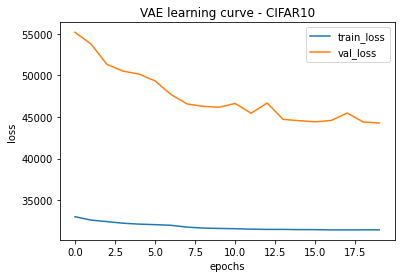

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trainLoss[:20],label='train_loss')
plt.plot(valLoss[:20],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('VAE learning curve - CIFAR10')
plt.legend()
plt.show()

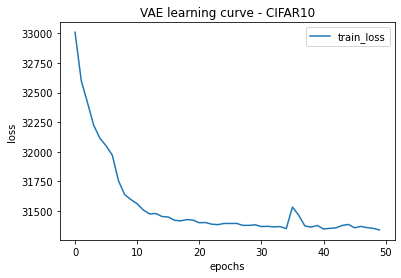

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trainLoss,label='train_loss')
# plt.plot(valLoss,label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('VAE learning curve - CIFAR10')
plt.legend()
plt.show()

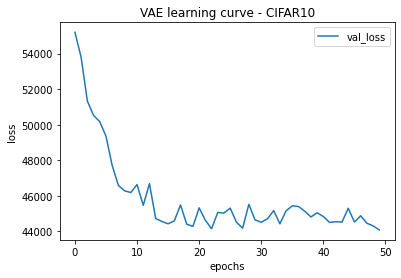

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(trainLoss,label='train_loss')
plt.plot(valLoss,label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('VAE learning curve - CIFAR10')
plt.legend()
plt.show()

In [ ]:
idx = np.random.randint(0,len(trainset))
x = trainloader.dataset[idx][0]
y = trainloader.dataset[idx][1]
(mean,logvar),decode = model.forward(x.view(-1,3,32,32).cuda())

In [ ]:

import matplotlib.pyplot as plt


In [ ]:
red = x[0].cpu().numpy()
green = x[1].cpu().numpy()
blue = x[2].cpu().numpy()
img = np.stack((red,green,blue),axis=2)

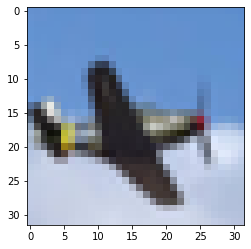

In [ ]:
plt.imshow(img*0.5+0.5)

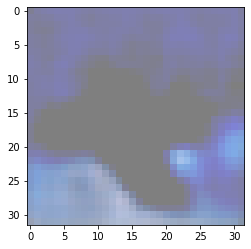

In [ ]:
x = decode.view(3,32,32)
red = x[0].detach().cpu().numpy()
green = x[1].detach().cpu().numpy()
blue = x[2].detach().cpu().numpy()
img = np.stack((red,green,blue),axis=2)
plt.imshow(img)